# Tracking Disease Outbreaks using News Headlines

Congratulations! You have just been hired by the American Institute of Health. The Institute monitors disease epidemics in both foreign and domestic lands. A critical component of the monitoring process is analyzing published news data. Each day, the Institute receives hundreds of news headlines describing disease outbreaks in various locations. The news headlines are too numerous to be analyzed by hand.

Your first assignment is as follows: You will process the daily quota of news headlines and extract locations that are mentioned You will then cluster the headlines based on their geographic distribution. Finally, you will review the largest clusters within and outside the United States. Any interesting findings should be reported to your immediate superior.

The file `headlines.txt` contains the hundreds of headlines that you must analyze. Each headline appears on a separate line in the file.

<aside>
📌 To address the problem at hand, we need to know how to do the following: 1) Cluster datasets using multiple techniques and distance measures. 2) Measure distances between locations on a spherical globe. 3) Visualize locations on a map. 4) Extract location coordinates from headline text.

</aside>

Our goal is to extract locations from disease-related headlines to uncover the largest active epidemics within and outside of the United States. We will do as follows:

1. Load the data.
2. Extract locations from the text using regular expressions and the GeoNamesCache library.
3. Check the location matches for errors.
4. Cluster the locations based on geographic distance.
5. Visualize the clusters on a map, and remove any errors.
6. Output representative locations from the largest clusters to draw interesting conclusions.

In [ ]:
!sudo apt-get install libgeos-3.5.0
!sudo apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip

!pip install geonamescache
!pip install unidecode

In [ ]:
!wget -q --show-progress https://raw.githubusercontent.com/sparsh-ai/general-recsys/T426474/siteD/Case_Study3/headlines.txt

headlines.txt       100%[===================>]  26.52K  --.-KB/s    in 0s      


In [ ]:
!head headlines.txt

Zika Outbreak Hits Miami
Could Zika Reach New York City?
First Case of Zika in Miami Beach
Mystery Virus Spreads in Recife, Brazil
Dallas man comes down with case of Zika
Trinidad confirms first Zika case
Zika Concerns are Spreading in Houston
Geneve Scientists Battle to Find Cure
The CDC in Atlanta is Growing Worried
Zika Infested Monkeys in Sao Paulo


## Extracting Locations from Headline Data

We'll begin by loading the headline data.

**Listing 12. 1. Loading headline data**

In [ ]:
headline_file = open('headlines.txt','r')
headlines = [line.strip() 
             for line in headline_file.readlines()]
num_headlines = len(headlines)
print(f"{num_headlines} headines have been loaded")

650 headines have been loaded


We need a mechanism for extracting city and country names from the headline text. One naïve solution is to match the locations in GeoNamesCache against each and every headline.  However, for more optimal matching, we should transform each location name into a case-independent and accent-independent regular expression. Lets execute these transformations using a custom `name_to_regex` function. 

**Listing 12. 2. Converting names to regexes**

In [ ]:
def name_to_regex(name):
    decoded_name = unidecode(name)
    if name != decoded_name:
        regex = fr'\b({name}|{decoded_name})\b'
    else:
        regex = fr'\b{name}\b'
    return re.compile(regex, flags=re.IGNORECASE)

Using `name_to_regex`, we can create create a mapping between regular expressions and the original names in GeoNamesCache.

**Listing 12. 3. Mapping names to regex**

In [ ]:
import re
from unidecode import unidecode
from geonamescache import GeonamesCache
gc = GeonamesCache()

In [ ]:
countries = [country['name'] 
             for country in gc.get_countries().values()]
country_to_name = {name_to_regex(name): name 
                   for name in countries}
                   
cities = [city['name'] for city in gc.get_cities().values()]
city_to_name = {name_to_regex(name): name for name in cities}

Next, we’ll use our mappings to define a function that will look for location names in text

**Listing 12. 4. Finding locations in text**

In [ ]:
def get_name_in_text(text, dictionary):
    for regex, name in sorted(dictionary.items(), 
                              key=lambda x: x[1]):
        if regex.search(text):
            return name
    return None

We'll utilize `get_names_in_text` to discover the cities and countries that are mentioned in the `headlines` list. Afterwards, we'll store the results in a Pandas table for easier analysis.

**Listing 12. 5. Finding locations in headlines**

In [ ]:
import pandas as pd

matched_countries = [get_name_in_text(headline, country_to_name)
                     for headline in headlines]
matched_cities = [get_name_in_text(headline, city_to_name)
                  for headline in headlines]
data = {'Headline': headlines, 'City': matched_cities, 
        'Country': matched_countries}
df = pd.DataFrame(data)

Lets explore our location table. We'll start by summarizing the contents of `df` using the `describe` method.

**Listing 12. 6. Summarizing the location data**

In [ ]:
summary = df[['City', 'Country']].describe()
print(summary)

       City Country
count   618      15
unique  511      10
top      Of  Brazil
freq     44       3


The most frequently mentioned city is apparently __Of, Turkey__. The 44 instances of __Of__ are more likely
to match the preposition than the rarely referenced Turkish location. We will output some instances of __Of__ in order to confirm the error.

**Listing 12. 7. Fetching cities named __Of__**

In [ ]:
of_cities = df[df.City == 'Of'][['City', 'Headline']]
ten_of_cities = of_cities.head(10)
print(ten_of_cities.to_string(index=False))

City                                                                 Headline
  Of                                    Case of Measles Reported in Vancouver
  Of  Authorities are Worried about the Spread of Bronchitis in Silver Spring
  Of      Authorities are Worried about the Spread of Mad Cow Disease in Rome
  Of                     Rochester authorities confirmed the spread of Dengue
  Of                           Tokyo Encounters Severe Symptoms of Meningitis
  Of        Authorities are Worried about the Spread of Influenza in Savannah
  Of                                  Spike of Pneumonia Cases in Springfield
  Of                      The Spread of Measles in Spokane has been Confirmed
  Of                                          Outbreak of Zika in Panama City
  Of                          Urbana Encounters Severe Symptoms of Meningitis


In all the wrongly matched headlines we matched to __Of__ but not to the actual city
name. The mismatches occurred because we didn't consider potential multiple matches in a headline. How frequently do headlines contain 2 or more city matches? Lets find out. 

**Listing 12. 8. Finding multi-city headlines**

In [ ]:
def get_cities_in_headline(headline):
    cities_in_headline = set()
    for regex, name in city_to_name.items():          
        match = regex.search(headline)
        if match:
            if headline[match.start()].isupper():
                cities_in_headline.add(name)
                
    return list(cities_in_headline)

df['Cities'] = df['Headline'].apply(get_cities_in_headline)
df['Num_cities'] = df['Cities'].apply(len)
df_multiple_cities = df[df.Num_cities > 1]
num_rows, _ = df_multiple_cities.shape
print(f"{num_rows} headlines match multiple cities")

71 headlines match multiple cities


71 headlines contain more than one city, representing approximately 10% of the data. Why are so many headlines matching against multiple locations? Perhaps exploring some sample matches will yield an answer.

**Listing 12. 9. Sampling multi-city headlines**

In [ ]:
ten_cities = df_multiple_cities[['Cities', 'Headline']].head(10)
print(ten_cities.to_string(index=False))

                        Cities                                                    Headline
         [York, New York City]                             Could Zika Reach New York City?
          [Miami Beach, Miami]                           First Case of Zika in Miami Beach
               [San, San Juan]  San Juan reports 1st U.S. Zika-related death amid outbreak
    [Los Angeles, Los Ángeles]                        New Los Angeles Hairstyle goes Viral
                  [Bay, Tampa]                       Tampa Bay Area Zika Case Count Climbs
        [Ho, Ho Chi Minh City]              Zika cases in Vietnam's Ho Chi Minh City surge
              [San Diego, San]                    Key Zika Findings in San Diego Institute
           [Kuala Lumpur, Hīt]                          Kuala Lumpur is Hit By Zika Threat
          [San Francisco, San]                            Zika Virus Reaches San Francisco
 [Salvador, San Salvador, San]                                Zika worries in San Salvador

Short, invalid city names are getting matched to the headlines along with longer, more correct location names. One solution is simply to assign the longest city-name as the representative location if more than one matched city is found.

**Listing 12. 10. Selecting the longest city names**

In [ ]:
def get_longest_city(cities):
    if cities:
        return max(cities, key=len)
    return None

df['City'] = df['Cities'].apply(get_longest_city)

As a sanity check, we'll output those rows in the the table that contain a short city-name (4 characters or less), in order to ensure that no erroneous short name is getting assigned to one of our headlines.

**Listing 12. 11. Printing the shortest city names**

In [ ]:
short_cities = df[df.City.str.len() <= 4][['City', 'Headline']]
print(short_cities.to_string(index=False))

 City                                                             Headline
 Lima                                  Lima tries to address Zika Concerns
 Pune                                       Pune woman diagnosed with Zika
 Rome  Authorities are Worried about the Spread of Mad Cow Disease in Rome
 Molo                                  Molo Cholera Spread Causing Concern
 Miri                                                 Zika arrives in Miri
 Nadi                 More people in Nadi are infected with HIV every year
 Baud        Rumors about Tuberculosis Spreading in Baud have been Refuted
 Kobe                                       Chikungunya re-emerges in Kobe
 Waco                                  More Zika patients reported in Waco
 Erie                                          Erie County sets Zika traps
 Kent                                         Kent is infested with Rabies
 Reno                   The Spread of Gonorrhea in Reno has been Confirmed
 Sibu                    

Let's now shift our attention from cities to countries. Only 15 of the total headlines contain actual country information. The count is low enough for us to manually examine all these headlines.

**Listing 12. 12. Fetching headlines with countries**

In [ ]:
df_countries = df[df.Country.notnull()][['City', 
                                         'Country', 
                                         'Headline']]
print(df_countries.to_string(index=False))

             City    Country                                                               Headline
           Recife     Brazil                                Mystery Virus Spreads in Recife, Brazil
 Ho Chi Minh City    Vietnam                         Zika cases in Vietnam's Ho Chi Minh City surge
          Bangkok   Thailand                                         Thailand-Zika Virus in Bangkok
       Piracicaba     Brazil                                    Zika outbreak in Piracicaba, Brazil
            Klang   Malaysia                                       Zika surfaces in Klang, Malaysia
   Guatemala City  Guatemala  Rumors about Meningitis spreading in Guatemala City have been refuted
      Belize City     Belize                                     Belize City under threat from Zika
         Campinas     Brazil                                       Student sick in Campinas, Brazil
      Mexico City     Mexico                                   Zika outbreak spreads to Mexico City


All of the country-bearing headlines also contain city information. Thus, we can assign a latitude and longitude without relying on the country's central coordinates. Consequently, we can disregard the country names from our analysis.

**Listing 12. 13. Dropping countries from the table**

In [ ]:
df.drop('Country', axis=1, inplace=True)

We are nearly ready to add latitudes and longitudes to our table. However, we first need to consider those rows where no locations were detected. Lets count the number of unmatched headlines, and then print a subset of that data.

**Listing 12. 14. Exploring unmatched headlines**

In [ ]:
df_unmatched = df[df.City.isnull()]
num_unmatched = len(df_unmatched)
print(f"{num_unmatched} headlines contain no city matches.")
print(df_unmatched.head(10)[['Headline']].values)

39 headlines contain no city matches.
[['Louisiana Zika cases up to 26']
 ['Zika infects pregnant woman in Cebu']
 ['Spanish Flu Sighted in Antigua']
 ['Zika case reported in Oton']
 ['Maka City Experiences Influenza Outbreak']
 ['West Nile Virus Outbreak in Saint Johns']
 ['Syphilis Hits Jefferson']
 ['Malaria Exposure in Sussex']
 ['Greenwich Establishes Zika Task Force']
 ['Will West Nile Virus vaccine help Parsons?']]


Approximately 6% of the headlines did not match any cities. Given that low frequency, we will delete the missing mentions.

**Listing 12. 15. Dropping unmatched headlines**

In [ ]:
df = df[~df.City.isnull()][['City', 'Headline']] 

## Visualizing and Clustering the Extracted Location Data

All the rows in our table contain a city-name. Now, we can assign a latitude and longitude to each row.

**Listing 12. 16. Assigning geographic coordinates to cities**

In [ ]:
latitudes, longitudes = [], []
for city_name in df.City.values:
    city = max(gc.get_cities_by_name(city_name), 
              key=lambda x: list(x.values())[0]['population'])
    city = list(city.values())[0]
    latitudes.append(city['latitude']) 
    longitudes.append(city['longitude'])

df = df.assign(Latitude=latitudes, Longitude=longitudes)

Lets execute K-means across our set of 2D coordinates. We'll use the Elbow method to choose a reasonable value for K.

**Listing 12. 17. Plotting a geographic elbow curve**

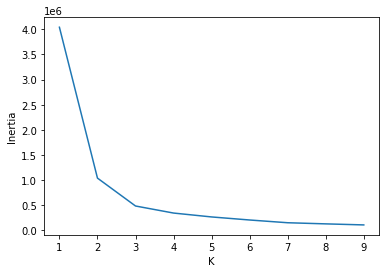

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

coordinates = df[['Latitude', 'Longitude']].values
k_values = range(1, 10)
inertia_values = []
for k in k_values:
    inertia_values.append(KMeans(k).fit(coordinates).inertia_)

plt.plot(range(1, 10), inertia_values)
plt.xlabel('K')
plt.ylabel('Inertia')
plt.show()

The "elbow" within our Elbow plot points to a K of 3 That K-value is very low; limiting our scope to at-most 3 different geographic territories.

**Listing 12. 18. Using K-means to cluster cities into 3 groups**

In [ ]:
from mpl_toolkits.basemap import Basemap

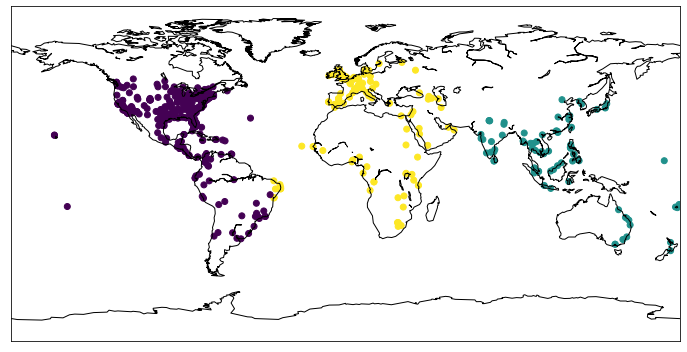

In [ ]:
def plot_clusters(clusters, longitudes, latitudes):
    fig = plt.figure(figsize=(12, 10))

    map_plotter = Basemap()
    map_plotter.scatter(longitudes, latitudes, c=clusters, latlon=True,
                        marker='o', alpha=1.0)
    map_plotter.drawcoastlines()
    plt.show()
    
df['Cluster'] = KMeans(3).fit_predict(coordinates)
plot_clusters(df.Cluster, df.Longitude, df.Latitude)

These continental categories are too broad to actually be useful. Perhaps our K was too low after all. We'll disregard the recommended K-value from the Elbow analysis, and double the size of K to 6.

**Using K-means to cluster cities into 6 groups**

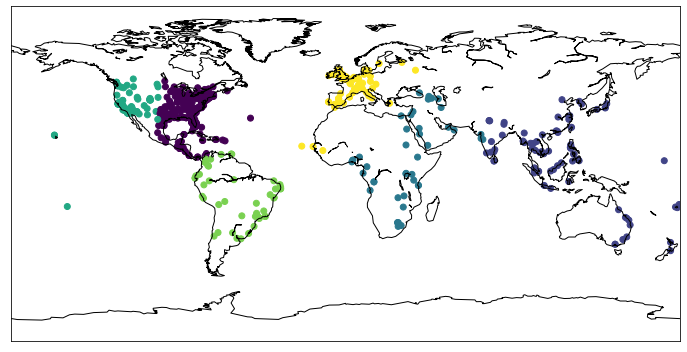

In [ ]:
df['Cluster'] = KMeans(6).fit_predict(coordinates)
plot_clusters(df.Cluster, df.Longitude, df.Latitude)

K-mean's sense of centrality is unable to properly distinguish between Africa, Europe and Asia. As an alternative approach, we can attempt to execute DBSCAN clustering. The DBSCAN algorithm takes as input any distance metric
of our choosing, allowing us to cluster on the great-circle distance between points.

**Listing 12. 20. Defining a NumPy-based great-circle metric**

In [ ]:
import numpy as np
from math import cos, sin, asin
from sklearn.cluster import DBSCAN

In [ ]:
def great_circle_distance(coord1, coord2, radius=3956):
    if np.array_equal(coord1, coord2):
        return 0.0 

    coord1, coord2 = np.radians(coord1), np.radians(coord2)
    delta_x, delta_y = coord2 - coord1
    haversin = sin(delta_x / 2) ** 2 + np.product([cos(coord1[0]),
                                                   cos(coord2[0]), 
                                                   sin(delta_y / 2) ** 2])
    return  2 * radius * asin(haversin ** 0.5)

With our distance metric in place, we are ready to run the DBSCAN algorithm. 

**Listing 12. 21. Using DBSCAN to cluster cities**

In [ ]:
metric = great_circle_distance
dbscan = DBSCAN(eps=250, min_samples=3, metric=metric)
df['Cluster'] = dbscan.fit_predict(coordinates)

DBSCAN assigns -1 to outlier data-points that do not cluster. Lets remove these outliers from our table. Afterwards, we’ll plot the remaining results.

**Listing 12. 22. Plotting non-outlier DBSCAN clusters**

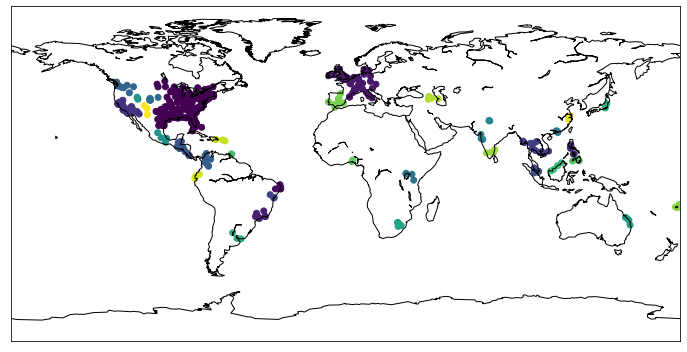

In [ ]:
df_no_outliers = df[df.Cluster > -1]
plot_clusters(df_no_outliers.Cluster, df_no_outliers.Longitude,
              df_no_outliers.Latitude)

DBSCAN has does a decent job of generating discrete clusters within parts of South America, Asia, and Southern Africa. The Eastern United States however, falls into a single overly-dense cluster. Lets cluster US locations independently from the rest of the World. To do so, we will first assign country-codes across each of our cities.

**Listing 12. 23. Assigning country codes to cities**

In [ ]:
def get_country_code(city_name):
    city = max(gc.get_cities_by_name(city_name), 
               key=lambda x: list(x.values())[0]['population'])
    return list(city.values())[0]['countrycode']

df['Country_code'] = df.City.apply(get_country_code)

The country-codes allow us to separate the data into 2 distinct `DataFrame` objects. The first object, `df_us`,  which hold all the United States locations. The second object, `df_not_us`, will hold all the remaining global cities.

**Listing 12. 24. Seperating US and global cities**

In [ ]:
df_us = df[df.Country_code == 'US']
df_not_us = df[df.Country_code != 'US']

We've separated US and non-US cities. Now, we will need to re-cluster the coordinates within the 2 separated tables. 

**Listing 12. 25. Re-clustering extracted cities**

In [ ]:
def re_cluster(input_df, eps):
    input_coord = input_df[['Latitude', 'Longitude']].values
    dbscan = DBSCAN(eps=eps, min_samples=3, 
                    metric=great_circle_distance)
    clusters = dbscan.fit_predict(input_coord)
    input_df = input_df.assign(Cluster=clusters)
    return input_df[input_df.Cluster > -1]

df_not_us = re_cluster(df_not_us, 250)
df_us = re_cluster(df_us, 125)

## Extracting Insights from Location Clusters

Lets investigate the clustered data within the `df_not_us` table. We'll start by grouping the clustered results using the Pandas `groupby` method.

**Listing 12. 26. Grouping cities by cluster**

In [ ]:
groups = df_not_us.groupby('Cluster')
num_groups = len(groups)
print(f"{num_groups} Non-US have been clusters detected")

31 Non-US have been clusters detected


31 global clusters have been detected. Lets sort these groups by size and count the headlines in the largest cluster.

**Listing 12. 27. Finding the largest cluster**

In [ ]:
sorted_groups = sorted(groups, key=lambda x: len(x[1]), 
                       reverse=True)
group_id, largest_group = sorted_groups[0]
group_size = len(largest_group)
print(f"Largest cluster contains {group_size} headlines")

Largest cluster contains 51 headlines


The largest cluster contains 51 total headlines. Reading all these headlines individually will be a time-consuming process. We can save time by outputting just those headlines that represent the most central locations in the cluster.

**Listing 12. 28. Computing cluster centrality**

In [ ]:
def compute_centrality(group):
    group_coords = group[['Latitude', 'Longitude']].values
    center = group_coords.mean(axis=0)
    distance_to_center = [great_circle_distance(center, coord)
                          for coord in group_coords]
    group['Distance_to_center'] = distance_to_center

Computing the centrality allows us to sort the grouped locations based on their distance to the centers, in order to output the most central headlines. Lets print the 5 most central headlines within our largest cluster.

**Listing 12. 29. Finding the central headlines in largest cluster**

In [ ]:
def sort_by_centrality(group):
    compute_centrality(group)
    return group.sort_values('Distance_to_center', ascending=True)

largest_group = sort_by_centrality(largest_group)
for headline in largest_group.Headline.values[:5]:
    print(headline)

Mad Cow Disease Disastrous to Brussels
Scientists in Paris to look for answers
More Livestock in Fontainebleau are infected with Mad Cow Disease
Mad Cow Disease Hits Rotterdam
Contaminated Meat Brings Trouble for Bonn Farmers


The central headlines in largest_cluster focus on an outbreak of Mad Cow Disease within various European cities. We can confirm that the cluster’s locale is centered in Europe by outputting the top countries associated with cities in the cluster.

**Listing 12. 30. Finding the top 3 countries in largest cluster**

In [ ]:
from collections import Counter
def top_countries(group):
    countries = [gc.get_countries()[country_code]['name']
                 for country_code in group.Country_code.values]
    return Counter(countries).most_common(3)


print(top_countries(largest_group))

[('United Kingdom', 19), ('France', 7), ('Germany', 6)]


Lets repeat this analysis across the next 4 largest global clusters.

**Listing 12. 31. Summarizing content within the largest clusters**

In [ ]:
for _, group in sorted_groups[1:5]:
    sorted_group = sort_by_centrality(group)
    print(top_countries(sorted_group))
    for headline in sorted_group.Headline.values[:5]:
        print(headline)
    print('\n')

[('Philippines', 15)]
Zika afflicts patient in Calamba
Hepatitis E re-emerges in Santa Rosa
Batangas Tourism Takes a Hit as Virus Spreads
More Zika patients reported in Indang
Spreading Zika reaches Bacoor


[('Thailand', 5), ('Cambodia', 3), ('Vietnam', 2)]
More Zika patients reported in Chanthaburi
Thailand-Zika Virus in Bangkok
Zika case reported in Phetchabun
Zika arrives in Udon Thani
More Zika patients reported in Kampong Speu


[('El Salvador', 3), ('Nicaragua', 2), ('Guatemala', 2)]
Zika arrives in Tegucigalpa
Zika Reported in Ilopango
More Zika cases in Soyapango
Zika worries in San Salvador
Spike of Rabies Cases in Managua


[('Spain', 8), ('Portugal', 2), ('Morocco', 1)]
Spanish flu spreading in Madrid
Rabies Hits Madrid
Spanish Flu Spreading through Madrid
Spanish Flu Spreading through Madrid
Zika Troubles come to Jaen




Lets turn our attention to the US clusters. We'll start by visualizing the clusters on a map of the United States.

**Listing 12. 32. Plotting United States DBSCAN clusters**

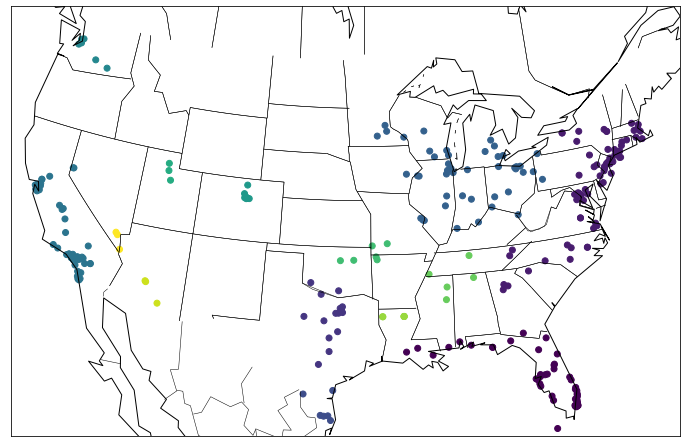

In [ ]:
fig = plt.figure(figsize=(12, 10))
map_lcc = Basemap(projection='lcc', llcrnrlon=-119,
                  llcrnrlat=22, urcrnrlon=-64, urcrnrlat=49,
                   lat_1=33, lat_2=45, lon_0=-95)

map_lcc.scatter(df_us.Longitude.values, df_us.Latitude.values,
                c=df_us.Cluster, latlon=True)
map_lcc.drawcoastlines()
map_lcc.drawstates()
plt.show()

The visualized map yields reasonable outputs. We'll proceed to analyze the top 5 US clusters by printing their centrality-sorted headlines.

**Listing 12. 33. Summarizing content within the largest US clusters**

In [ ]:
us_groups = df_us.groupby('Cluster')
us_sorted_groups = sorted(us_groups, key=lambda x: len(x[1]),
                         reverse=True)
for _, group in us_sorted_groups[:5]:
    sorted_group = sort_by_centrality(group)
    for headline in sorted_group.Headline.values[:5]:
        print(headline)
    print('\n')

Schools in Bridgeton Closed Due to Mumps Outbreak
Philadelphia experts track pandemic
Vineland authorities confirmed the spread of Chlamydia
Baltimore plans for Zika virus
Will Swine Flu vaccine help Annapolis?


Bradenton Experiences Zika Troubles
Tampa Bay Area Zika Case Count Climbs
Zika Strikes St. Petersburg
New Zika Case Confirmed in Sarasota County
Zika spreads to Plant City


Rhinovirus Hits Bakersfield
Schools in Tulare Closed Due to Mumps Outbreak
Santa Barbara tests new cure for Hepatitis C
New medicine wipes out West Nile Virus in Ventura
Hollywood Outbreak Film Premieres


How to Avoid Hepatitis E in South Bend
Hepatitis E Hits Hammond
Chicago's First Zika Case Confirmed
Rumors about Hepatitis C spreading in Darien have been refuted
Rumors about Rotavirus Spreading in Joliet have been Refuted


More Zika patients reported in Fort Worth
Outbreak of Zika in Stephenville
Zika symptoms spotted in Arlington
Dallas man comes down with case of Zika
Zika spreads to Lewisville




Lets plot one additional image. It will summarize the menacing scope of the spreading Zika epidemic. The image will display all US and global clusters where Zika is mentioned in more than 50% of article headlines.

**Listing 12. 34. Plotting Zika clusters**

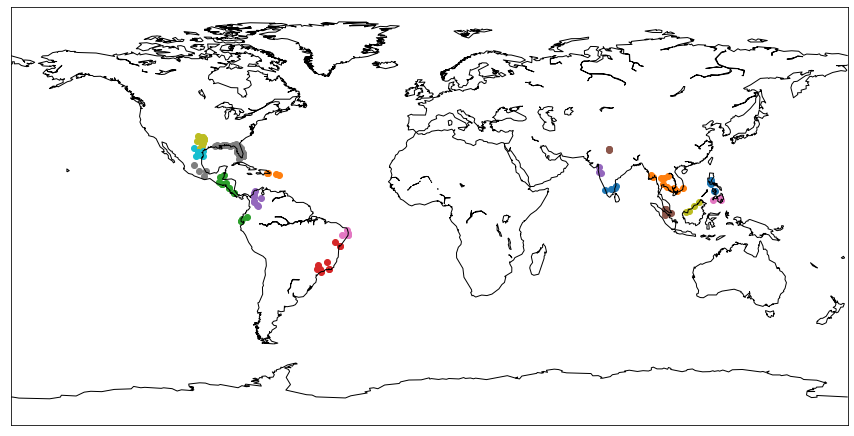

In [ ]:
def count_zika_mentions(headlines):
    zika_regex = re.compile(r'\bzika\b', 
                            flags=re.IGNORECASE)
    zika_count = 0
    for headline in headlines:
        if zika_regex.search(headline): 
            zika_count += 1
    
    return zika_count

fig = plt.figure(figsize=(15, 15))
map_plotter = Basemap()

for _, group in sorted_groups + us_sorted_groups:
    headlines = group.Headline.values
    zika_count = count_zika_mentions(headlines)
    if float(zika_count) / len(headlines) > 0.5:
        map_plotter.scatter(group.Longitude.values, 
                            group.Latitude.values,
                            latlon=True)
map_plotter.drawcoastlines()
plt.show()